In [49]:
import sklearn 
from sklearn import datasets, utils, preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

if __name__ == '__main__':
    wine = sklearn.datasets.load_wine()
    dataset = pd.DataFrame(data = np.c_[wine['data'], wine['target']],columns=wine['feature_names']+['target'])

- 'np.c_' server per spacchettare e ripacchettare

Ora vediamo range di dati , media , per studiare un po' come variano i diversi dati

In [50]:
print("\nData Describe")
print(dataset.describe())
print("\nData Head")
print(dataset.head())


Data Describe
          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   


Nelle prime istanze il target vale 0 , ciò può influenzare la train-test split perché magari posso prendere 
solo le prime istanze per allenare , di conseguenza il modello sarà allenato solo nei casi di target = 0

In [51]:
print("\nData types:")
dataset.dtypes


Data types:


alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                          float64
dtype: object

In [52]:
print("\nConteggio NaN")
dataset.isna().sum


Conteggio NaN


<bound method NDFrame._add_numeric_operations.<locals>.sum of      alcohol  malic_acid    ash  alcalinity_of_ash  magnesium  total_phenols  \
0      False       False  False              False      False          False   
1      False       False  False              False      False          False   
2      False       False  False              False      False          False   
3      False       False  False              False      False          False   
4      False       False  False              False      False          False   
..       ...         ...    ...                ...        ...            ...   
173    False       False  False              False      False          False   
174    False       False  False              False      False          False   
175    False       False  False              False      False          False   
176    False       False  False              False      False          False   
177    False       False  False              False      Fa

In [53]:
print("\nVerifica valori variabile target")
print(dataset['target'].unique())
print("\nConteggio valori variabile target")
print(dataset['target'].value_counts())


Verifica valori variabile target
[0. 1. 2.]

Conteggio valori variabile target
1.0    71
0.0    59
2.0    48
Name: target, dtype: int64


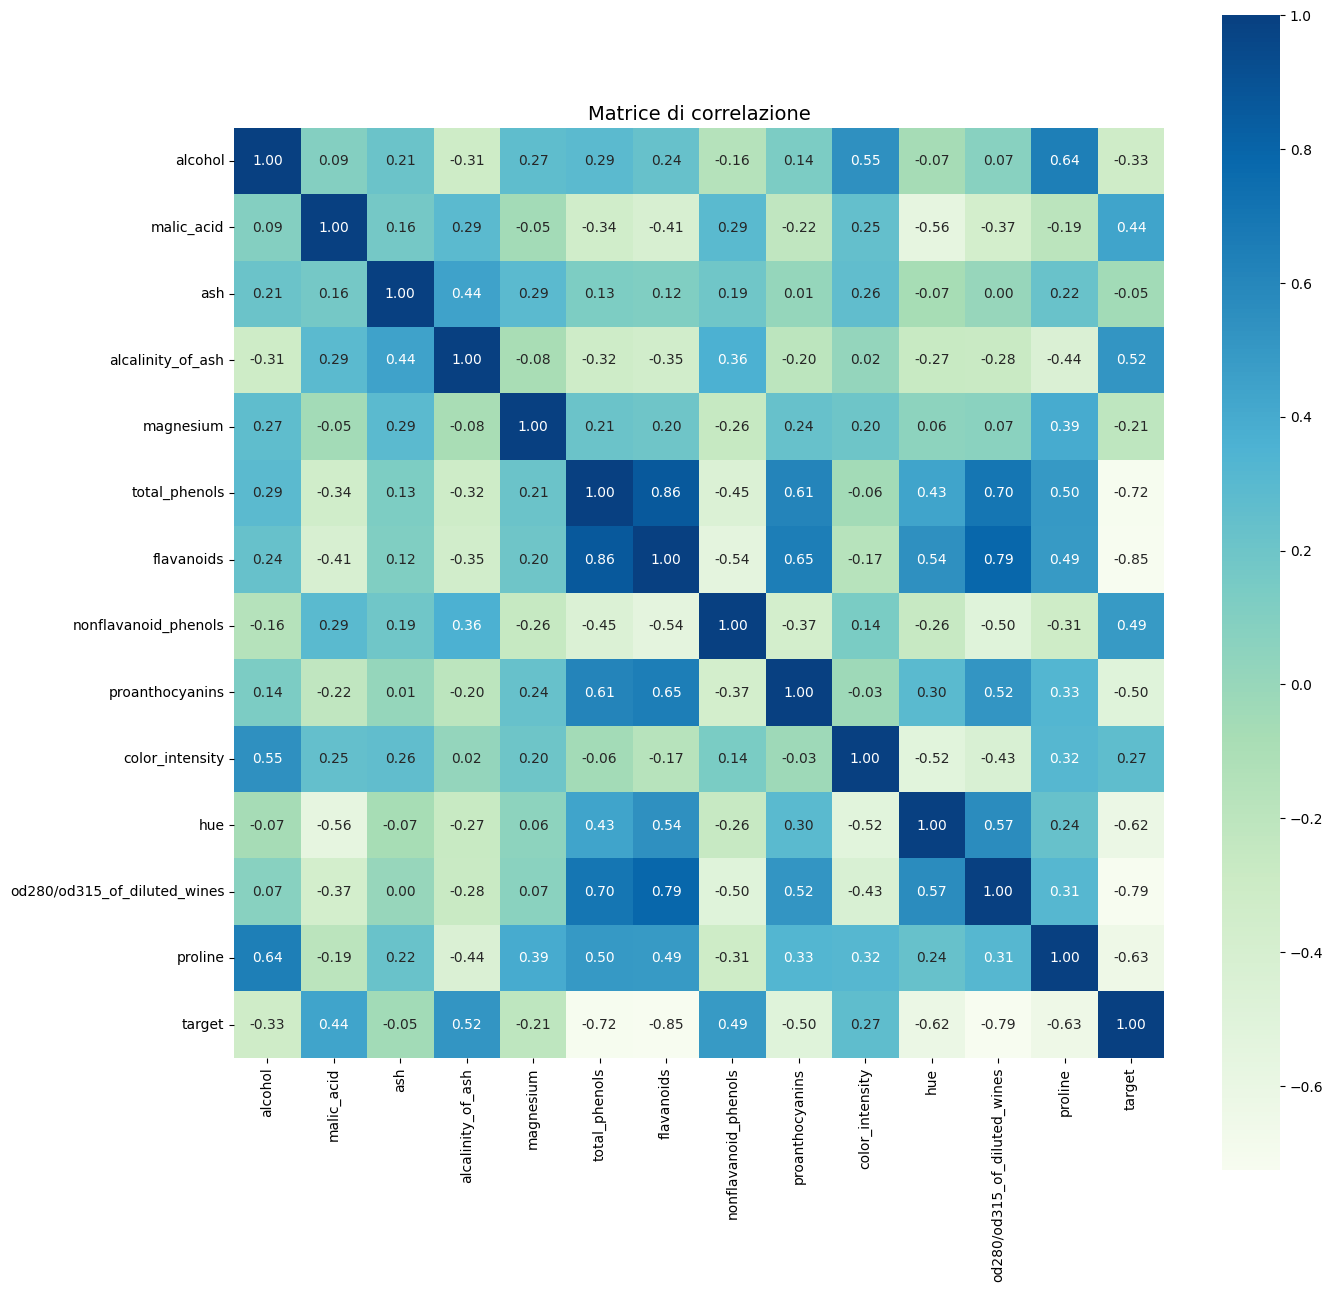

In [54]:
corr_matrix = dataset.corr()
plt.figure(figsize=(15, 15))
plot = sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, fmt='.2f', cmap='GnBu', robust=True)
plt.title('Matrice di correlazione', fontsize=14)
plt.show()

In [55]:
#Vado a creare una funz che rimuove le variabili che non hanno a che fare con la var target
def remove_unrelated_variability_with_target(df_model, target, threshold): #target=stringa
        corr = df_model.corr() #ricalcoliamo matrice di corr
        corr_target = abs(corr['target']) #faccio l'abs del val target della matrice di corr
        relevant_features = corr_target[corr_target > threshold] #prendo i valori della matr solo se il val target > threshold
        
        print('\nFeatures correlation with target >', threshold)
        print(relevant_features)
        print('\nFeatures correlated: ', len(relevant_features))
        
        relevant_features_col = relevant_features.keys().tolist() 
        
        new_df = df_model[relevant_features_col]
        
        return new_df
    
df_target = remove_unrelated_variability_with_target(dataset, 'target', 0.5)


Features correlation with target > 0.5
alcalinity_of_ash               0.517859
total_phenols                   0.719163
flavanoids                      0.847498
hue                             0.617369
od280/od315_of_diluted_wines    0.788230
proline                         0.633717
target                          1.000000
Name: target, dtype: float64

Features correlated:  7


Andiamo a scrivere una funzione di classificazione dell'attributo target sfruttando anche la funzione di SMOTE


Before y train value counts:
 1.0    57
0.0    46
2.0    39
Name: target, dtype: int64
Before y test value counts:
 1.0    14
0.0    13
2.0     9
Name: target, dtype: int64

Y train value counts:
 1.0    57
2.0    57
0.0    57
Name: target, dtype: int64
Y test value counts:
 1.0    14
0.0    14
2.0    14
Name: target, dtype: int64


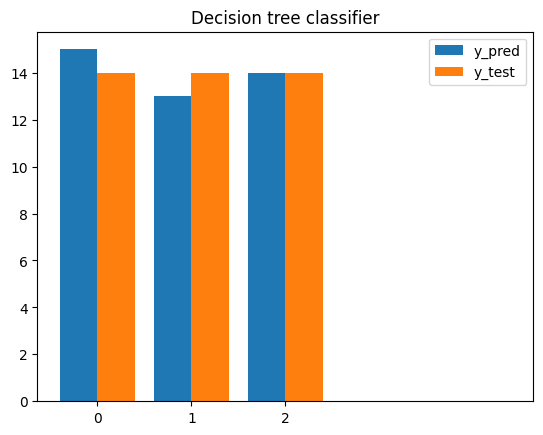

In [56]:
#Scriviamo la funzione di classificazione con SMOTE
def classification(dataframe):
    x = dataframe.drop('target', axis=1) #Separiamo insieme att dalla variabile target
    y = dataframe['target']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True) #shuffle=True va a mischiare il dataset per risolvere quel problema del train set
    
    print("\nBefore y train value counts:\n", y_train.value_counts())
    print("Before y test value counts:\n", y_test.value_counts())  #per verificare che la var target sia ben rappresentata
    
    smote = SMOTE(sampling_strategy='not majority', random_state=32) #andiamo ad aumentare l'insieme di train e di test
    x_train, y_train = smote.fit_resample(x_train, y_train)
    x_test, y_test = smote.fit_resample(x_test, y_test)
    
    #Verifichiamo come sono cambiati gli insiemi di train e di test
    print("\nY train value counts:\n", y_train.value_counts())
    print("Y test value counts:\n", y_test.value_counts()) 
    
    #definisco il classificatore e faccio addestramento
    classifier = DecisionTreeClassifier()
    classifier.fit(x_train, y_train)    #forniamo insieme etichette e insieme valori istanze
    y_pred = classifier.predict(x_test)
    
    #creiamo istogramma in cui vedere risultati classificatore
    plt.hist([y_pred, y_test], bins=[0, 1, 2, 3, 4, 5], label=['y_pred', 'y_test'], align='left') #vogliamo vedere sia predetta che textper legenda
    plt.xticks([0,1,2])
    plt.yscale('linear')
    plt.title('Decision tree classifier')
    plt.legend()
    plt.show()
    
classification(dataset)

In [57]:
#Rifaccio la funzione di classificazione ma questa volta uso la cross-validation
def mammeta(dataframe):
    X = dataframe.drop('target', axis=1)
    y = dataframe['target']
    
    #Resamplo il dataset
    sm=SMOTE()
    X_res, y_res = sm.fit_resample(X,y)
    
    #Creo una train-test split con la serie di target e il resto del dataframe
    X_train, X_test, y_train, y_test = train_test_split( X_res, y_res, test_size=0.33, random_state=7345, shuffle=True)
    
    #Creo albero di classificazione
    dtc = DecisionTreeClassifier(random_state=42)
    dtc.fit(X_train, y_train)
    
    #Calcolo tutte le metriche del classificatore
    y_pred = dtc.predict(X_test)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    #Eseguo cross-validation per 'migliorare' il classificatore
    scoring = {'precision':'precision_macro', 'recall':'recall_macro', 'f1_score':'f1_macro', 'accuracy':'accuracy'}
    score = cross_validate(dtc, X_res, y_res, scoring=scoring)
    cross_precision = score['test_precision'].mean()
    cross_accuracy = score['test_accuracy'].mean()
    cross_f_score = score['test_f1_score'].mean()
    cross_recall = score['test_recall'].mean()
    
    #Stampiamo metriche di valutazione, matrice di confusione e report di classificazione
    print('Accuracy:', accuracy)
    print('Precision:',precision)
    print('Recall:',recall)
    print('F_score:',f1)
    print('Matrice di confusione:\n',confusion)
    print(report)
    
    #Stampiamo le metriche della cross validation
    print('Cross precision:',cross_precision)
    print('Cross accuracy:',cross_accuracy)
    print('Cross recall:',cross_recall)
    print('Cross f_score:',cross_f_score)
    
mammeta(dataset)

Accuracy: 0.8732394366197183
Precision: 0.8804075235109718
Recall: 0.8879012345679013
F_score: 0.8747429318264813
Matrice di confusione:
 [[24  1  0]
 [ 5 19  3]
 [ 0  0 19]]
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89        25
         1.0       0.95      0.70      0.81        27
         2.0       0.86      1.00      0.93        19

    accuracy                           0.87        71
   macro avg       0.88      0.89      0.87        71
weighted avg       0.88      0.87      0.87        71

Cross precision: 0.9330945419103314
Cross accuracy: 0.9203765227021041
Cross recall: 0.9193650793650795
Cross f_score: 0.917814485241801
